In [150]:
x = torch.arange(8).reshape(2, 4)

In [151]:
x.is_contiguous()

True

In [152]:
x.view(2, 2, 2).is_contiguous()

True

In [153]:
x = x.reshape(4, 2)
x.view(2, 2, 2).is_contiguous()

True

In [156]:
x.t().view(4, 2)

RuntimeError: view size is not compatible with input tensor's size and stride (at least one dimension spans across two contiguous subspaces). Use .reshape(...) instead.

# MiniGato

From the paper [A Generalist Agent](https://arxiv.org/abs/2205.06175).

The paper doesn't introduce a new architecture. Instead, the paper is all about tokenizing, embedding, and sequencing data from multiple modalities (text, image, proprioception) in such a way that it can be learned by a transformer.

Reproducing the paper is more of a software design exercise than an ML research exercise. How would you structure the data manipulation code – the tokenization, embedding, and sequencing of different modalities – in a way that's correct, easy to understand and extend, and performant?

In [19]:
import mini_gato
import mini_gato.util
import importlib
importlib.reload(mini_gato.util)

<module 'mini_gato.util' from '/home/eihli/src/mini_gato/mini_gato/util.py'>

In [20]:
from abc import ABC, abstractmethod
from collections import defaultdict, OrderedDict
from itertools import cycle
import math
import os
from pathlib import Path
import pdb
import random
import re
import tempfile
from typing import List, Protocol
from dataclasses import dataclass, fields
import datasets
from einops import rearrange
from functools import partial
from mini_gato.nano_gpt import GPT, GPTConfig
import numpy as np
import matplotlib.pyplot as plt
import minari
from mini_gato.util import (
    tensor_as_gif, TransformDataset,
    images_to_patches, patches_to_images, normalize_to_between_minus_one_plus_one,
    apply_along_dimension, discretize, undiscretize,
    interleave, deinterleave,
)
import minigrid.core
import requests
from timm.models.resnetv2 import ResNetV2
import tiktoken
import torch
import torch.nn.functional as F
import torchvision.transforms.v2 as transforms
from torchvision.transforms.functional import pil_to_tensor
from torch.utils.data import Dataset, DataLoader

In [21]:
text_tokenizer = tiktoken.get_encoding("r50k_base")

In [22]:
text_tokenizer.encode("foobar")

[6513, 30973]

In [23]:
text_tokenizer.eot_token

50256

## Tokenization [§ 2.1](https://arxiv.org/pdf/2205.06175)

> There are infinite possible ways to transform data into tokens, including directly using the raw underlying byte stream.

We're going to start off with a certain set of tokenization strategies for a certain set of modalities. We might want to expand that in the future. When that happens, I don't want to have to edit code in the PyTorch Module that implements our model code. I'd rather be able to add a new class of modality that implements a "tokenization" signature.

In [24]:
class TextTokenizer(Protocol):
    n_vocab: int
    eot_token: int
    def encode(self, text: str) -> List[int]:
        ...
    def decode(self, tokens: List[int]) -> str:
        ...

class Tokenizer:
    def __init__(self, text_tokenizer: TextTokenizer):
        self.text_tokenizer = text_tokenizer
        self.eot_token = text_tokenizer.eot_token
        self.n_text = text_tokenizer.n_vocab
        self.n_discrete = 1024
        self.n_modalities = 1024
        self.boa_token = 1023  # Separator between observation and action.

    # It's useful to know if tokens are of a particular modality – text, image, discrete, etc...
    #
    # Why?
    #
    # Embedding, for example. Images get embedded with a ResNetV2 block. Text and
    # discrete get embedded with an nn.Embedding lookup table.
    #
    # We can tell what modality something is by simply checking the range of its tokens.
    # Text is in the range [0, 50256) for the tiktoken tokenizer.
    # Discrete and continuous are in the range [50257, 51281) – the 1024 tokens after vocab.
    # Images are floats and have a different shape because they get patched.
    def is_text(self, tokens: torch.Tensor) -> bool:
        return 0 <= tokens[0, 0, 0] < self.n_text

    def is_discrete(self, tokens: torch.Tensor) -> bool:
        return self.n_text <= tokens[0, 0, 0] < self.n_text + self.n_discrete

    def is_image(self, tokens: torch.Tensor) -> bool:
        return tokens.size(-1) > 1  # Images are the only modality that have a channel dim > 1.

    def encode_text(self, text: str) -> torch.Tensor:
        return torch.tensor([self.eot_token, *self.text_tokenizer.encode(text), self.eot_token]).reshape(1, -1, 1)

    def decode_text(self, tokens: torch.Tensor) -> str:
        return self.text_tokenizer.decode(tokens.squeeze()[1:-1].tolist())
        
    def encode_discrete(self, tokens: List[int], is_action=False) -> torch.Tensor:
        if is_action:
            return (torch.tensor([self.boa_token] + tokens) + self.n_text).reshape(1, -1, 1)
        else:
            return (torch.tensor(tokens) + self.n_text).reshape(1, -1, 1)
        
    def decode_discrete(self, tokens: torch.Tensor) -> List[int]:
        return (tokens - self.n_text).squeeze().tolist()

    # TODO:
    # The paper says to mu-law encode continuous values.
    # We're not doing that yet.
    def encode_continuous(self, tokens: List[float], is_action=False) -> torch.Tensor:
        if is_action:
            return (discretize(torch.tensor([self.boa_token] + tokens)) + self.n_text).reshape(1, -1, 1)
        else:
            return (discretize(torch.tensor(tokens)) + self.n_text).reshape(1, -1, 1)

    # This is going to be a lossy decode. The paper says to clip companded values so that
    # they fall within the range [-1, 1]. The paper says actions are only defined in the range [-1, 1]
    # for all of their environments, so it doesn't hurt in practice. But if you expect to be able
    # to compand/uncompand, you'll be disappointed.
    def decode_continuous(self, tokens: torch.Tensor) -> List[float]:
        return undiscretize(self, tokens).tolist()

    def encode_image(self, image, patch_size=16):
        patches = images_to_patches(image, patch_size=patch_size)
        xs = (
            apply_along_dimension(
                normalize_to_between_minus_one_plus_one, 1, patches
            )
            / math.sqrt(patch_size)
        )        
        return xs.unsqueeze(0)
    
    def decode_image(self, tokens, image_shape=(3, 192, 192), patch_size=16):
        # Lossy because I'm not saving the values used for scaling from encoding.
        patches = (tokens * math.sqrt(patch_size) + 1) / 2
        images = patches_to_images(patches, image_shape, patch_size=patch_size)
        return images        

#### Examples

In [25]:
x = torch.arange(-2, 5) * 1.5
x, discretize(x), undiscretize(discretize(x), x.min(), x.max())

(tensor([-3.0000, -1.5000,  0.0000,  1.5000,  3.0000,  4.5000,  6.0000]),
 tensor([   0,  171,  342,  512,  682,  853, 1023]),
 tensor([-2.9956, -1.4927,  0.0103,  1.5044,  2.9985,  4.5015,  5.9956]))

Think about how you would tokenize and batch the examples below?

Keep in mind: samples might have different numbers of episodes and different numbers of tokens for a given key ('mission', 'image', 'action', etc...)

- One sample might have 19 episodes with a mission of "reach the goal".
- Another sample might have 12 episodes with a mission of "find the green key".
- Another might have 17 episodes where the first 10 have a mission of "find the green key" and the last 7 have a mission of "exit through the green door".

All of that means you're going to have to pad along several different dimensions.

Note that we can't stack these until both pad _and_ embed.

In [26]:
examples = [
    {
        # Continuous/Discrete/Text looks like this:
        #
        #                                 Episodes
        #                                 |  Tokens
        #                                 |  |  Channels
        #                                 |  |  |
        'mission': torch.arange(2*3).view(2, 3, 1),
        # Images look like this:
        #
        #                                  Episodes
        #                                  |  Height
        #                                  |  |  Width
        #                                  |  |  |  Channels
        #                                  |  |  |  |
        'image': torch.randn(2*7*7*3).view(2, 7, 7, 3),
        'action': torch.arange(2*1).view(2, 1, 1),
    },
    {
        'mission': torch.arange(3*4).view(3, 4, 1),
        'image': torch.randn(2*7*7*3).view(2, 7, 7, 3),
        'action': torch.arange(3*1).view(3, 1, 1),
    },
]

In [27]:
tokenizer = Tokenizer(text_tokenizer)

In [28]:
tokens = tokenizer.encode_text("Hello, world!")
tokens.shape, tokens

(torch.Size([1, 6, 1]),
 tensor([[[50256],
          [15496],
          [   11],
          [  995],
          [    0],
          [50256]]]))

In [29]:
tokenizer.decode_text(tokens)

'Hello, world!'

In [30]:
tokens = tokenizer.encode_discrete([0, 1, 2, 3])
tokens.shape, tokens

(torch.Size([1, 4, 1]),
 tensor([[[50257],
          [50258],
          [50259],
          [50260]]]))

In [31]:
tokenizer.decode_discrete(tokens)

[0, 1, 2, 3]

## Image prep

In [32]:
normalize = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
denormalize = transforms.Normalize([-0.485/0.229, -0.456/0.224, -0.406/0.255], [1/0.229, 1/0.224, 1/0.225])

In [33]:
image_transform = transforms.Compose([
    transforms.ToDtype(torch.float32, scale=True),
    transforms.RandomResizedCrop((192, 192), (1.0, 1.0)),
    normalize,
])

## Padding and slicing to fit context window

In [34]:
SEQUENCE_LENGTH = 1024

In [35]:
# These next 5 functions are helpers for when we need have a sample with
# a large number of episodes and creating a sequence from all of them would
# be larger than our context window.
#
# These helpers pick a random index for an episode from the sample
# and then slice up to the greatest index that's within our max sequence length.

def episode_num_tokens(sample):
    return sum([len(v[0]) for v in sample.values()])

def sample_num_tokens(sample):
    return episode_num_tokens(sample) * next(iter(sample.values())).size(0)

def sequence_episode_capacity(sequence_length, sample):
    return sequence_length // episode_num_tokens(sample)

def random_episode_start_index(sequence_length, sample):
    cap = min(next(iter(sample.values())).size(0), sequence_episode_capacity(sequence_length, sample))
    return random.randint(0, cap)

def slice_to_context_window(sequence_length, sample):
    result = OrderedDict()
    n = random_episode_start_index(1024, sample)
    m = sequence_episode_capacity(1024, sample)
    for k in sample.keys():
        result[k] = sample[k][n:n+m]
    return result

In [36]:
# There's a hidden depency in all of this code that `batch` is an OrderedDict.
# The order of the keys is the order we'll use to create a sequence of observations for training.
def pad(batch, padding_value=0):
    padded = OrderedDict()
    for k, v in batch[0].items():
        episode_length = max(sample[k].size(0) for sample in batch)
        token_length = max(sample[k].size(1) for sample in batch)
        for sample in batch:
            pad = (0, 0, 0, token_length - sample[k].size(1), 0, episode_length - sample[k].size(0))
            padded[k] = padded.get(k, [])
            padded[k].append(F.pad(sample[k], pad, value=0))
    return OrderedDict([
        (k, torch.stack(v))
        for k, v in padded.items()
    ])

def mask(batch):
    result = OrderedDict()
    for k, v in batch[0].items():
        episode_lengths = [sample[k].size(0) for sample in batch]
        token_lengths = [sample[k].size(1) for sample in batch]
        result[k] = torch.zeros(len(batch), max(episode_lengths), max(token_lengths))
        for i in range(len(batch)):
            result[k][i][:episode_lengths[i], :token_lengths[i]] = 1
    return result

## Datasets

### The Four Rooms Dataset

Each dataset will need a few customized functions to manipulate the data into something a transformer can use.

In the case of the Four Rooms Dataset, that means converting a discrete description of a grid into an image. We probably could have gotten by with encoding the grid as discrete observations. But images give us spatial information thanks to the patch position encoding. Plus, it doesn't seem like it would hurt anything to have more visual data to train on.

The functions you'll need for most datasets will be:

- miscellanous manipulations, like the Four Rooms grid-observation to an image
- tokenizer
- collate function

In [37]:
# Some FourRooms/Minigrid-specific stuff to turn
# a 7x7x3 non-pixel observation into an pixel/image observation.
lut = np.zeros((256, 3), dtype=np.uint8)
for idx, color_name in minigrid.core.constants.IDX_TO_COLOR.items():
    lut[idx] = minigrid.core.constants.COLORS[color_name]

def four_rooms_to_rgb(images):
    """Convert discrete "image" observations into actual images.
    I'm expecting this will improve our image modality while not losing
    much. The downside is we can fit less in our context window. Note:
    We might need to overlay the color/type image (index 1) with the
    state image (index 2), if we really don't want to lose any info."""
    # Apply lookup to second channel
    return torch.from_numpy(lut[images[:, :, :, 1]]).permute(0, 3, 1, 2)    

def tokenize_four_rooms(tokenizer, episode):
    mission_tokens = [tokenizer.encode_text(mission) for mission in episode.observations["mission"][:-1]]
    direction_tokens = [tokenizer.encode_discrete(direction) for direction in episode.observations["direction"][:-1]]
    image = episode.observations["image"][:-1]
    image = four_rooms_to_rgb(image)
    image_tokens = [tokenizer.encode_image(image) for image in image_transform(image)]
    action_tokens = [tokenizer.encode_discrete(action, is_action=True) for action in episode.actions]
    return OrderedDict({
        'mission': torch.concat(mission_tokens),
        'direction': torch.concat(direction_tokens), 
        'image': torch.concat(image_tokens),
        'action': torch.concat(action_tokens),
    })

def four_rooms_collate_fn(batch, sequence_length=1024):
    sliced = [slice_to_context_window(sequence_length, sample) for sample in batch]
    padded = pad(sliced)
    return padded, mask(sliced)

In [38]:
four_rooms_dataset = minari.load_dataset('D4RL/minigrid/fourrooms-v0', download=True)

In [39]:
four_rooms_dataset_xf = TransformDataset(four_rooms_dataset, partial(tokenize_four_rooms, tokenizer))

In [40]:
four_rooms_dataset_xf[0]['mission'].shape, four_rooms_dataset_xf[0]['action'].shape

(torch.Size([19, 5, 1]), torch.Size([19, 1, 1]))

In [42]:
batch = [four_rooms_dataset_xf[i] for i in range(4)]

In [43]:
padded, masked = four_rooms_collate_fn(batch)

In [44]:
[padded[p].shape for p in padded.keys()]

[torch.Size([4, 6, 5, 1]),
 torch.Size([4, 6, 1, 1]),
 torch.Size([4, 6, 144, 768]),
 torch.Size([4, 6, 1, 1])]

In [45]:
[masked[p].shape for p in masked.keys()]

[torch.Size([4, 6, 5]),
 torch.Size([4, 6, 1]),
 torch.Size([4, 6, 144]),
 torch.Size([4, 6, 1])]

In [46]:
batch[1].keys()

odict_keys(['mission', 'direction', 'image', 'action'])

#### Exploring the Four Rooms dataset - Images

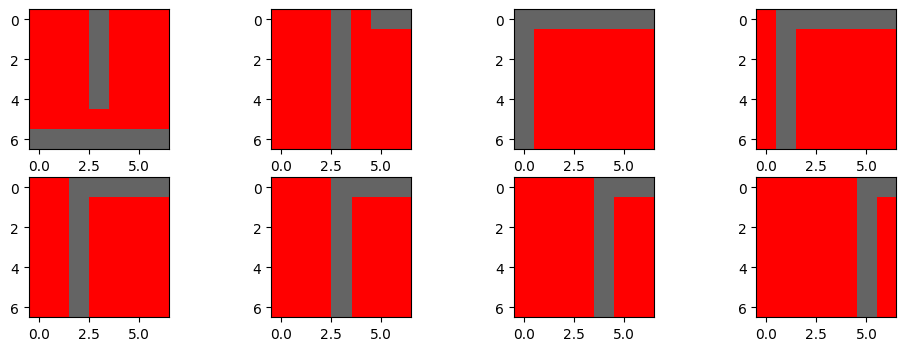

In [47]:
fig, axs = plt.subplots(2, 4, figsize=(12, 4))
for i in range(2):
    for j in range(4):
        axs[i][j].imshow(four_rooms_to_rgb(four_rooms_dataset[0].observations['image'][[i*4+j]])[0].permute(1, 2, 0))

In [48]:
four_rooms_dataset[0].observations['image'][[i]].shape

(1, 7, 7, 3)

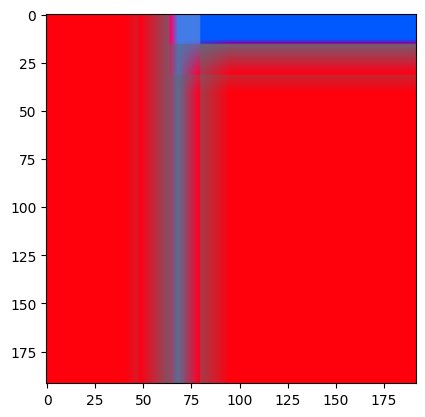

In [49]:
patches = four_rooms_dataset_xf[0]['image']
plt.imshow(tokenizer.decode_image(patches).permute(0, 2, 3, 1)[4])

In [50]:
patches = four_rooms_dataset_xf[0]['image']
tokenizer.decode_image(patches);

In [51]:
B, T, C = four_rooms_dataset_xf[0]['image'].shape

In [52]:
four_rooms_dataset_xf[0]['image'].reshape(B, T, 3, 16, 16).shape

torch.Size([19, 144, 3, 16, 16])

In [53]:
tokenizer.decode_image(four_rooms_dataset_xf[0]['image']).shape

torch.Size([19, 3, 192, 192])

In [54]:
four_rooms_dataset[0].observations['image'].shape
# 20 "episodes" (or "steps" that the robot took to complete the task)
# 7x7 grid of vision at each step
# 3 "channels". NOT RGB. (object_type, object_color, object_state)

(20, 7, 7, 3)

In [55]:
images = four_rooms_to_rgb(four_rooms_dataset[0].observations['image'])
images.shape, images[0]

(torch.Size([20, 3, 7, 7]),
 tensor([[[255, 255, 255, 100, 255, 255, 255],
          [255, 255, 255, 100, 255, 255, 255],
          [255, 255, 255, 100, 255, 255, 255],
          [255, 255, 255, 100, 255, 255, 255],
          [255, 255, 255, 100, 255, 255, 255],
          [255, 255, 255, 255, 255, 255, 255],
          [100, 100, 100, 100, 100, 100, 100]],
 
         [[  0,   0,   0, 100,   0,   0,   0],
          [  0,   0,   0, 100,   0,   0,   0],
          [  0,   0,   0, 100,   0,   0,   0],
          [  0,   0,   0, 100,   0,   0,   0],
          [  0,   0,   0, 100,   0,   0,   0],
          [  0,   0,   0,   0,   0,   0,   0],
          [100, 100, 100, 100, 100, 100, 100]],
 
         [[  0,   0,   0, 100,   0,   0,   0],
          [  0,   0,   0, 100,   0,   0,   0],
          [  0,   0,   0, 100,   0,   0,   0],
          [  0,   0,   0, 100,   0,   0,   0],
          [  0,   0,   0, 100,   0,   0,   0],
          [  0,   0,   0,   0,   0,   0,   0],
          [100, 100, 100, 

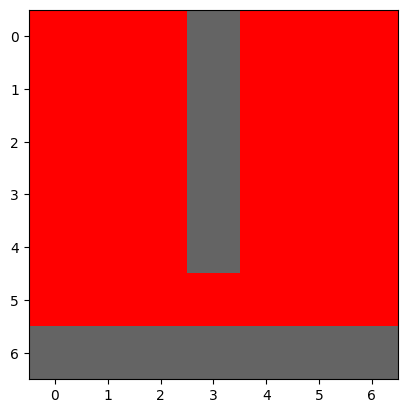

In [56]:
plt.imshow(images[0].permute(1, 2, 0))

In [57]:
from PIL import Image
from IPython.display import display, Image as IPythonImage

In [58]:
# Converting them to PIL Images gives us a convenient way to save the images as a GIF.
images = four_rooms_to_rgb(four_rooms_dataset[0].observations['image'])
images = images.permute(0, 2, 3, 1).numpy()
images = [Image.fromarray(image) for image in images]
images[:3]

[<PIL.Image.Image image mode=RGB size=7x7>,
 <PIL.Image.Image image mode=RGB size=7x7>,
 <PIL.Image.Image image mode=RGB size=7x7>]

In [59]:
import io
# But there's a better way!
buffer = io.BytesIO()
images[0].save(
    buffer,
    format='GIF',
    save_all=True,
    append_images=images[1:],
    duration=200,
    loop=0,
)
buffer.seek(0)
display(IPythonImage(data=buffer.getvalue(), width=192, height=192))

In [60]:
four_rooms_dataloader = DataLoader(four_rooms_dataset_xf, batch_size=4, collate_fn=four_rooms_collate_fn)

In [61]:
batch = next(iter(four_rooms_dataloader))

In [62]:
batch[0]['mission'].shape

torch.Size([4, 6, 5, 1])

### Visual Question Answering Dataset

In [63]:
vqa_dataset = datasets.load_dataset("eihli/micro-ok-vqa")

In [64]:
def tokenize_vqa(tokenizer, sample):
    question = [tokenizer.encode_text(sample["question"])]
    image = [tokenizer.encode_image(image_transform(pil_to_tensor(sample["image"])))]
    answer = [tokenizer.encode_text(random.choice(sample["answers"])["answer"])]
    return OrderedDict({
        'question': torch.stack(question),
        'image': torch.stack(image),
        'answer': torch.stack(answer),
    })

def vqa_collate_fn(batch, sequence_length=1024):
    sliced = [slice_to_context_window(sequence_length, sample) for sample in batch]
    padded = pad_tokens(sliced)
    masked = mask(batch)
    return padded, masked

In [65]:
sample = vqa_dataset['train'][0]

In [66]:
tokens = tokenizer.encode_image(image_transform(pil_to_tensor(sample["image"])))

In [67]:
tokens.shape, tokens

(torch.Size([1, 144, 768]),
 tensor([[[-0.2378, -0.2437, -0.2390,  ...,  0.1854,  0.1832,  0.1849],
          [-0.2446, -0.2466, -0.2453,  ...,  0.2264,  0.2325,  0.2391],
          [-0.1818, -0.1153, -0.0956,  ...,  0.2149,  0.2101,  0.2130],
          ...,
          [ 0.0385,  0.0600,  0.0706,  ...,  0.2237,  0.2288,  0.2367],
          [ 0.0707,  0.0894,  0.1001,  ...,  0.2478,  0.2362,  0.0630],
          [-0.0377, -0.0938, -0.1630,  ...,  0.1883,  0.1839,  0.1875]]]))

In [68]:
vqa_dataset_xf = TransformDataset(vqa_dataset["train"], partial(tokenize_vqa, tokenizer))

In [69]:
sample = four_rooms_dataset_xf[0]

In [70]:
sample = vqa_dataset_xf[0]
(
    sample['question'].shape, 
    sample['image'].shape, 
    tokenizer.decode_text(sample['answer'][0]), 
    tokenizer.decode_text(sample['question'][0])
)

(torch.Size([1, 1, 12, 1]),
 torch.Size([1, 1, 144, 768]),
 'pony tail',
 'What is the hairstyle of the blond called?')

In [71]:
sample['answer'][0].tolist()

[[[50256], [79], [1647], [7894], [50256]]]

### Shakespeare Dataset

In [72]:
def acquire_shakespeare_dataset():
    temp_dir = tempfile.gettempdir()
    shakespeare_filepath = Path(temp_dir)/"shakespeare.txt"
    if not os.path.exists(shakespeare_filepath):
        data_url = 'https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt'
        with open(shakespeare_filepath, 'w', encoding='utf-8') as f:
            f.write(requests.get(data_url).text)
    
    with open(shakespeare_filepath, 'r', encoding='utf-8') as f:
        data = f.read()

    # Split the dataset into each character's lines.
    # Continue taking lines until you have at least 250 words in the sample.
    # Add that sample to the dataset.
    characters_lines = re.split(r"\n\s*\n", data.strip())
    MIN_WORDS_PER_BATCH = 250
    sample = [characters_lines[0]]
    num_words_in_sample = len(characters_lines[0].split())
    text_dataset = []
    i = 1
    while i < len(characters_lines):
        if num_words_in_sample > MIN_WORDS_PER_BATCH:
            text_dataset.append("\n\n".join(sample))
            num_words_in_sample -= len(sample[0].split())
            sample = sample[1:]
        sample += [characters_lines[i]]
        num_words_in_sample += len(characters_lines[i].split())
        i += 1

    return text_dataset

In [73]:
shakespeare_dataset = acquire_shakespeare_dataset()

In [74]:
print(f"Number of samples in the dataset: {len(shakespeare_dataset)}")
print(f"Character length of first 3 samples: {[len(x) for x in shakespeare_dataset[:3]]}\n")
print(f"First 80 characters of first sample:\n\n{shakespeare_dataset[0][:80]}")

Number of samples in the dataset: 7184
Character length of first 3 samples: [1632, 1688, 1891]

First 80 characters of first sample:

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.


In [75]:
def tokenize_shakespeare(tokenizer, sample):
    text = [tokenizer.encode_text(sample)]
    return OrderedDict({
        'text': torch.concat(text),
    }) 

def shakespeare_collate_fn(batch, sequence_length=1024):
    padded = pad(batch)
    masked = mask(batch)
    return padded, masked

In [76]:
shakespeare_dataset_xf = TransformDataset(shakespeare_dataset, partial(tokenize_shakespeare, tokenizer))
shakespeare_dataloader = DataLoader(shakespeare_dataset_xf, batch_size=4, collate_fn=shakespeare_collate_fn)

In [77]:
batch = [shakespeare_dataset_xf[i] for i in range(4)]

In [78]:
batch[0]['text'].shape

torch.Size([1, 454, 1])

In [79]:
batched, masked = next(iter(shakespeare_dataloader))

In [80]:
batched.keys(), batched['text'].shape, masked['text'].shape, masked

(odict_keys(['text']),
 torch.Size([4, 1, 522, 1]),
 torch.Size([4, 1, 522]),
 OrderedDict([('text',
               tensor([[[1., 1., 1.,  ..., 0., 0., 0.]],
               
                       [[1., 1., 1.,  ..., 0., 0., 0.]],
               
                       [[1., 1., 1.,  ..., 1., 1., 1.]],
               
                       [[1., 1., 1.,  ..., 0., 0., 0.]]]))]))

## Embedding

In [81]:
EMBEDDING_DIMS = 512

In [82]:
image_embedding = ResNetV2(layers=[3, 4, 6, 3], num_classes=EMBEDDING_DIMS)
lookup_embedding = torch.nn.Embedding(tokenizer.n_text + tokenizer.n_discrete + tokenizer.n_modalities, EMBEDDING_DIMS)

In [83]:
batch, masked = next(iter(four_rooms_dataloader))

In [84]:
image_tokens = batch['image']
image_tokens.shape

torch.Size([4, 6, 144, 768])

In [85]:
B, E, T, C = image_tokens.shape
patch_size=16

In [86]:
patch_tokens = image_tokens.view(B*E*T, 3, patch_size, patch_size)
patch_embeddings = image_embedding(patch_tokens).view(B, E, T, -1)

In [87]:
patch_tokens.shape

torch.Size([3456, 3, 16, 16])

In [88]:
patch_embeddings.shape

torch.Size([4, 6, 144, 512])

In [89]:
mission_tokens = batch['mission']
mission_tokens.shape

torch.Size([4, 6, 5, 1])

In [90]:
B, E, T, C = mission_tokens.shape

In [91]:
mission_tokens.view(B*E*T, -1).shape

torch.Size([120, 1])

In [92]:
mission_embeddings = lookup_embedding(mission_tokens).view(B, E, T, -1)
mission_embeddings.shape

torch.Size([4, 6, 5, 512])

In [93]:
from typing import Callable
@dataclass
class Embedder:
    tokenizer: Tokenizer
    lookup_embedding: Callable
    image_embedding: Callable

    def embed(self, data):
        B, E, T, C = data.shape
        if self.tokenizer.is_image(data):
            #                                         (C,  P,  P)
            return self.image_embedding(data.view(B*E*T, 3, 16, 16)).view(B, E, T, -1)
        else:
            return self.lookup_embedding(data.view(B*E*T)).view(B, E, T, -1)

def sequence(embedder, batch, mask, sequence_length=1024):
    embeddings = torch.concat([embedder.embed(v) for k, v in batch.items()], dim=2)
    masks = torch.concat([v for _, v in mask.items()], dim=2)
    B, E, T, C = embeddings.shape
    embeddings = embeddings.view(B, E*T, C)
    masks = masks.view(B, E*T)
    return (
        F.pad(embeddings, (0, 0, 0, sequence_length - embeddings.size(1), 0, 0), value=0),
        F.pad(masks, (0, sequence_length - embeddings.size(1), 0, 0), value=0),
    )

In [94]:
embedder = Embedder(tokenizer, lookup_embedding, image_embedding)

In [95]:
mission_tokens.shape

torch.Size([4, 6, 5, 1])

In [96]:
embedder.embed(mission_tokens).shape

torch.Size([4, 6, 5, 512])

In [97]:
embedder.embed(image_tokens).shape

torch.Size([4, 6, 144, 512])

In [98]:
batch, masks = next(iter(four_rooms_dataloader))

In [99]:
batch['mission'].shape, masks['mission'].shape

(torch.Size([4, 6, 5, 1]), torch.Size([4, 6, 5]))

In [100]:
embeddings = torch.concat([embedder.embed(v) for k, v in batch.items()], dim=2)

In [101]:
embeddings.shape

torch.Size([4, 6, 151, 512])

In [102]:
torch.concat([v for v in masks.values()], dim=2).shape

torch.Size([4, 6, 151])

In [103]:
B, E, T, C = embeddings.shape
embeddings.view(B, E*T, C).shape

torch.Size([4, 906, 512])

In [104]:
masks['image'].shape

torch.Size([4, 6, 144])

In [105]:
type(batch), type(masks)

(collections.OrderedDict, collections.OrderedDict)

In [106]:
seq, msk = sequence(embedder, batch, masks)

In [107]:
seq.shape, msk.shape

(torch.Size([4, 1024, 512]), torch.Size([4, 1024]))

In [108]:
bch, msk = sequence(embedder, batch, masks)

In [109]:
bch.shape, msk.shape

(torch.Size([4, 1024, 512]), torch.Size([4, 1024]))

In [110]:
batched, masked = next(iter(shakespeare_dataloader))

In [111]:
seq, msk = sequence(embedder, batched, masked)

In [112]:
seq.shape, msk.shape

(torch.Size([4, 1024, 512]), torch.Size([4, 1024]))

In [113]:
msk

tensor([[1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.]])

## Continuous Dataset

In [114]:
pointmaze_dataset = minari.load_dataset('D4RL/pointmaze/open-v2', download=True)

In [115]:
pointmaze_dataset[0].observations.keys()

dict_keys(['achieved_goal', 'desired_goal', 'observation'])

In [116]:
def tokenize_pointmaze(tokenizer, sample):
    goal_tokens = [tokenizer.encode_continuous(goal) for goal in sample.observations["desired_goal"][:-1]]
    action_tokens = [tokenizer.encode_continuous(action, is_action=True) for action in sample.actions]
    return OrderedDict({
        'goal': torch.concat(goal_tokens),
        'action': torch.concat(action_tokens), 
    })

def pointmaze_collate_fn(batch, sequence_length=1024):
    sliced = [slice_to_context_window(sequence_length, sample) for sample in batch]
    padded = pad(sliced)
    if padded['goal'].size(1) == 0:
        pdb.set_trace()
    return padded, mask(sliced)

In [117]:
pointmaze_dataset_xf = TransformDataset(pointmaze_dataset, partial(tokenize_pointmaze, tokenizer))
pointmaze_dataloader = DataLoader(pointmaze_dataset_xf, batch_size=4, collate_fn=pointmaze_collate_fn)

In [118]:
it = iter(pointmaze_dataloader)

In [147]:
batched, masked = next(it)

In [148]:
[v.shape for v in batched.values()]

[torch.Size([4, 157, 2, 1]), torch.Size([4, 157, 2, 1])]

In [121]:
batch = [pointmaze_dataset_xf[i] for i in range(4)]

In [127]:
batch[0].values();

In [130]:
pointmaze_collate_fn(batch)[0]['action'].shape

torch.Size([4, 72, 2, 1])

In [ ]:
shakespeare_dataset_xf = TransformDataset(shakespeare_dataset, partial(tokenize_shakespeare, tokenizer))
shakespeare_dataloader = DataLoader(shakespeare_dataset_xf, batch_size=4, collate_fn=shakespeare_collate_fn)